# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [120]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tabulate import tabulate
%matplotlib inline

In [121]:
def vectorize_feature(feature, test=False):
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(feature)
        fitted_transformations.append(hv)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(feature)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    return(X_hv)

In [122]:
def apply_term_frequency_weight_to_feature(feature_to_weight, test=False):
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(feature_to_weight)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(feature_to_weight)
    return X_tfidf

In [123]:
def scale_matrix_of_features(features, test=False):
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(features)
        fitted_transformations.append(sc)
    else:
        X = fitted_transformations[2].transform(features)
        print(X.shape)
    return(X)

In [124]:
# function that takes raw data and completes all preprocessing required before model fits
def create_training_and_test_sets(my_random_seed, test=False):
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [148]:
def print_report():
    print("\033[94m" + "movie_data is:\n" + "\033[0m", type(movie_data))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "movie_data has:\n" + "\033[0m")
    shape_table = [("Rows", movie_data.shape[0]), ("Columns", movie_data.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "the data types for each of the columns in movie_data:\n" + "\033[0m")
    print(movie_data.dtypes, "\n")
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Sample Review:\n" + "\033[0m")
    print(corpus_of_reviews[0])
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "the first 10 rows in movie_data:\n" + "\033[0m")
    print(movie_data.head(5))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "The rate of 'good' movie reviews in the dataset:\n" + "\033[0m")
    print(movie_data['sentiment'].mean())
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Shape of HashingVectorizer X:\n" + "\033[0m")
    shape_table = [("Reviews", X_hv.shape[0]), ("Terms", X_hv.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Look at a few rows of the new quantitative features:\n" + "\033[0m")
    print(tabulate(new_quant_features[:10], headers=["Word Count", "Punctuation Count"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Size of combined bag of words and new quantitative variables matrix:\n" + "\033[0m")
    shape_table = [("Reviews", X_stacked_matrix_of_features.shape[0]), ("Terms", X_stacked_matrix_of_features.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Shape of X_train and X_test:\n" + "\033[0m")
    shape_table = [("Reviews", X_train.shape[0]), ("Terms", X_train.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n")
    shape_table = [("Reviews", X_test.shape[0]), ("Terms", X_test.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Shape of y_train and y_test:\n" + "\033[0m")
    shape_table = [("Reviews", y_train.shape[0])]
    print(tabulate(shape_table, headers=["Size"]))
    print("\n")
    shape_table = [("Reviews", y_test.shape[0])]
    print(tabulate(shape_table, headers=["Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Shape of X_raw_train and X_raw_test:\n" + "\033[0m")
    shape_table = [("Reviews", X_raw_train.shape[0]), ("Terms", X_raw_train.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n")
    shape_table = [("Reviews", X_raw_test.shape[0]), ("Terms", X_raw_test.shape[1])]
    print(tabulate(shape_table, headers=["Dimension", "Size"]))
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + "Number of fits stored in `fitted_transformations` list:\n" + "\033[0m")
    print(len(fitted_transformations))
    print("\n" + "-"*40 + "\n")
    print("\n" + "-"*40 + "\n")
    print("\033[94m" + 'SUCCESS!' + "\033[0m")

In [205]:
def clean_corpus_of_reviews(corpus_of_reviews):
    import re
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    from tqdm import tqdm
    import pandas as pd

    nltk.download('stopwords')

    total_reviews = len(corpus_of_reviews)  # This dynamically gets the total number of reviews

    corpus = []
    ps = PorterStemmer()  # Placed out here for performance reasons
    stop_words = set(stopwords.words('english'))  # Placed out here for performance reasons

    for i in tqdm(range(total_reviews), desc="Cleaning reviews: "):
        review = corpus_of_reviews[i]
        review = re.sub('!+', '!', review)
        review = re.sub('[^a-zA-Z!]', ' ', review)
        #review = review.lower()
        review_words = review.split()
        cleaned_review = [ps.stem(word) for word in review_words if word not in stop_words]
        cleaned_review = ' '.join(cleaned_review)
        corpus.append(cleaned_review)
    
    return(pd.Series(corpus))

# Creating training and test sets

In [206]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

movie_data = pd.read_csv('moviereviews_train.tsv', sep='\t')
corpus_of_reviews = movie_data['review']

corpus_of_reviews = clean_corpus_of_reviews(corpus_of_reviews)

X_hv = vectorize_feature(corpus_of_reviews)
X_tfidf_sparse = apply_term_frequency_weight_to_feature(X_hv)

# create additional quantitative features
new_quant_features = []
new_quant_features.append(corpus_of_reviews.str.split(' ').str.len())
new_quant_features.append(corpus_of_reviews.str.count("!"))
new_quant_features = np.array(new_quant_features).T
new_quant_features_sparse = csr_matrix(new_quant_features)

X_stacked_matrix_of_features = hstack([new_quant_features_sparse]) # <---- Removed the weighted sparse matrix
X = scale_matrix_of_features(X_stacked_matrix_of_features)

y = movie_data['sentiment']
    
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = create_training_and_test_sets(my_random_seed=92)

print_report()

[nltk_data] Downloading package stopwords to /Users/main/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cleaning reviews: 100%|██████████████████| 25000/25000 [00:46<00:00, 535.33it/s]


movie_data is:
 <class 'pandas.core.frame.DataFrame'>

----------------------------------------

movie_data has:

Dimension      Size
-----------  ------
Rows          25000
Columns           3

----------------------------------------

the data types for each of the columns in movie_data:

id           object
sentiment     int64
review       object
dtype: object 


----------------------------------------

Sample Review:

with stuff go moment mj start listen music watch odd documentari watch the wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas some subtl messag mj feel toward press also obviou messag drug bad kay br br visual impress cours michael jackson unless remot like mj anyway go hate find bore some may call mj egotist consent make movi but mj fan would say made fan true realli nice br br the actual featur film bit final start minut exclu

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [207]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_error")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 6126, 'TN': 3870, 'FP': 6111, 'FN': 3893, 'Accuracy': 0.4998, 'Precision': 0.5006128953174798, 'Recall': 0.6114382672921449, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [208]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 1074, 'TN': 9195, 'FP': 786, 'FN': 8945, 'Accuracy': 0.51345, 'Precision': 0.5774193548387097, 'Recall': 0.10719632697874039, 'desc': 'svm_train'}


### MODEL: logistic regression

In [209]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log_loss')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 0, 'TN': 9981, 'FP': 0, 'FN': 10019, 'Accuracy': 0.49905, 'Precision': nan, 'Recall': 0.0, 'desc': 'lgs_train'}


/Users/main/Documents/GitHub/herson-xyz-labs/MFADT-Machine-Learning---Jupyter-Notebook/MFADT Machine Learning Class/Assignment 1/Herson, Seed 92 - v1/my_measures.py:25: RuntimeWarning: invalid value encountered in scalar divide
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### MODEL: Naive Bayes

In [210]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 7412, 'TN': 2672, 'FP': 7309, 'FN': 2607, 'Accuracy': 0.5042, 'Precision': 0.503498403641057, 'Recall': 0.7397943906577503, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [211]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 0, 'TN': 9981, 'FP': 0, 'FN': 10019, 'Accuracy': 0.49905, 'Precision': nan, 'Recall': 0.0, 'desc': 'prc_train'}


/Users/main/Documents/GitHub/herson-xyz-labs/MFADT-Machine-Learning---Jupyter-Notebook/MFADT Machine Learning Class/Assignment 1/Herson, Seed 92 - v1/my_measures.py:25: RuntimeWarning: invalid value encountered in scalar divide
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### MODEL: Ridge Regression Classifier

In [212]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 3798, 'TN': 6374, 'FP': 3607, 'FN': 6221, 'Accuracy': 0.5086, 'Precision': 0.5128966914247131, 'Recall': 0.379079748477892, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [213]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10019, 'Neg': 9981, 'TP': 2848, 'TN': 7741, 'FP': 2240, 'FN': 7171, 'Accuracy': 0.52945, 'Precision': 0.559748427672956, 'Recall': 0.2842599061782613, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

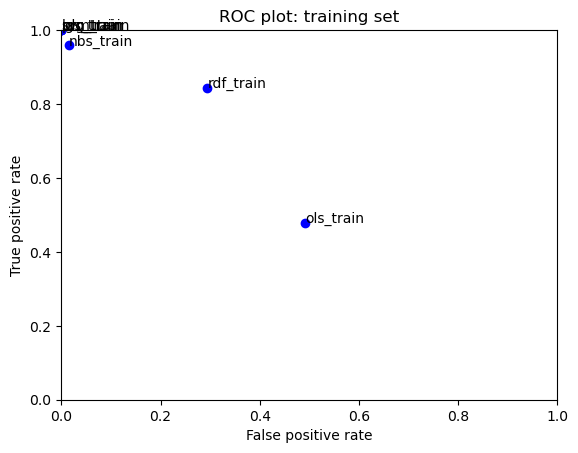

In [106]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [107]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [108]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
220
Please, someone stop Ben Stiller from acting in ANY movie. Write the studios, hell, write your local congressman even. I've gotten more laughs going to a funeral then I have watching ANY Stiller flick. Jack Black tries to make something about a comedy about disappearing dog crap, and Christopher Walken, perhaps on of the greatest actors of his generation, simply looks embarrassed to be there. Stiller is his unfunny self,but now even with someone to bail him out, proves that he is way overrated as a comic. It's no wonder why this movie tanked badly, and was available of the dollar movie theaters after only a handful of weeks. I warn you, and you must warn your friends, Do not watch this flick, it is just awful, worst then Gothika (personally, i'd never thought i'd say that), worst the Plan 9, Worst the Ishtar, worst then The Golden Child. Please Hollywood, quit allowing Ben Stiller in your movies, he's not funny, he's a god awful actor, and he's bringing

11460
And that is the only reason I posses this DVD. Now I haven't seen the first Nemesis film, but I did check the info out of it and I here by say: What? Why? Because in the first film Alex was male. But then again the first one was set in the future, so maybe this Alex is brand new one and the scientist just happened to make Alex female this time. Who knows, at least it wasn't addressed in the film in any way.<br /><br />Here's a quick summary of the plot: Alex, still a baby then (or how ever you want, as it was, is, in the future) escapes with her mom using a special time vessel and ends up in the 80's Africa. There mommy gets killed and Alex (Sue Price) grows up in a African tribe. Then the tribe gets slaughtered by a cyborg from the future and Alex then runs and hides and finally she kills the cyborg. So there. Does sound familiar, doesn't it?.<br /><br />Terminator isn't the only film being ripped here, Predator gets its fair share too and I think the first Fly movie, the Vincen

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [40]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 1271, 'TN': 1251, 'FP': 1268, 'FN': 1210, 'Accuracy': 0.5044, 'Precision': 0.500590783773139, 'Recall': 0.5122934300685208, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [41]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 2049, 'TN': 2086, 'FP': 433, 'FN': 432, 'Accuracy': 0.827, 'Precision': 0.8255439161966156, 'Recall': 0.8258766626360339, 'desc': 'svm_test'}


### MODEL: logistic regression

In [42]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 2091, 'TN': 2095, 'FP': 424, 'FN': 390, 'Accuracy': 0.8372, 'Precision': 0.8314115308151093, 'Recall': 0.8428053204353083, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [43]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 1815, 'TN': 1861, 'FP': 658, 'FN': 666, 'Accuracy': 0.7352, 'Precision': 0.7339264051758997, 'Recall': 0.7315598548972189, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [44]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 2092, 'TN': 2107, 'FP': 412, 'FN': 389, 'Accuracy': 0.8398, 'Precision': 0.8354632587859425, 'Recall': 0.8432083837162434, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [45]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 2060, 'TN': 2022, 'FP': 497, 'FN': 421, 'Accuracy': 0.8164, 'Precision': 0.8056315995307001, 'Recall': 0.8303103587263201, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [46]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2481, 'Neg': 2519, 'TP': 2052, 'TN': 1751, 'FP': 768, 'FN': 429, 'Accuracy': 0.7606, 'Precision': 0.7276595744680852, 'Recall': 0.8270858524788391, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

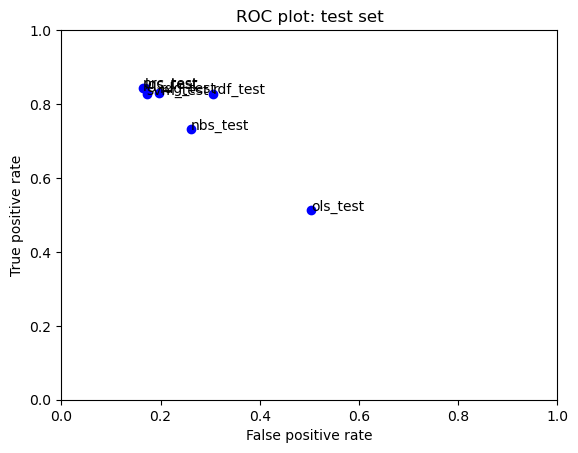

In [47]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=92, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation